In [38]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram

import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv('IBMQ_API_KEY')
QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_key, overwrite=True)

# IBM Quantum 서비스 연결 (API 토큰 필요)
service = QiskitRuntimeService()
print("Available backends:", service.backends())

# 원하는 백엔드 선택 (예: ibm_brisbane)
backend_name = "ibm_brisbane"
backend = service.backend(backend_name)
# 해당 백엔드의 노이즈 모델 생성
noise_model = NoiseModel.from_backend(backend)

print("Backend qubit count:", backend.num_qubits)
print("Backend name:", backend)
print(noise_model)
t1s = [backend.properties().t1(i) for i in range(backend.num_qubits)]
t2s = [backend.properties().t2(i) for i in range(backend.num_qubits)]
print("T1 times:", t1s)
print("T2 times:", t2s)

# 시뮬레이터에 노이즈 모델 적용
sim_noise = AerSimulator(noise_model=noise_model)

Available backends: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]
Backend qubit count: 127
Backend name: <IBMBackend('ibm_brisbane')>
NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'x', 'ecr', 'sx', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5

Result(backend_name='aer_simulator', backend_version='0.16.0', qobj_id='', job_id='e3f342b5-6693-43c0-94b2-d539df67be93', success=True, results=[ExperimentResult(shots=10000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x3': 4728, '0x0': 4840, '0x1': 221, '0x2': 211}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=2.356194490192345, memory_slots=2, n_qubits=2, name='circuit-62092', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=3177145911, metadata={'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'density_matrix', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0226829, 'sample_measure_time': 0.0012841, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 49078, 'measure_sampling': True, 'noise': 'superop', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': 

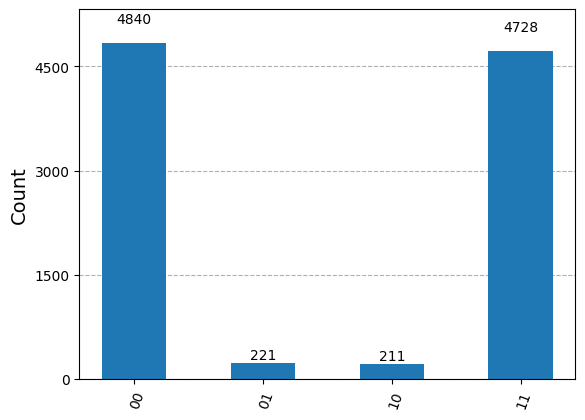

In [48]:
# 예시 회로 생성 (Bell State)
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

# 시뮬레이터용 회로 변환
from qiskit.transpiler import generate_preset_pass_manager
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
qc_t = passmanager.run(qc)

# 시뮬레이션 실행
result = sim_noise.run(qc_t, shots=10000).result()
print(result)
counts = result.get_counts(0)
print(counts)

# 결과 시각화
plot_histogram(counts)

In [50]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from modules.QGenerator import QGAN_ibmq
from modules.utils import read_args


epoch = 271
base_dir = "2d_results/InfoQGAN"
args_file_path = os.path.join(base_dir, 'args.txt')
param_file_path = os.path.join(base_dir, 'params', f'generator_params_epoch{epoch}.pth')
generator_params = torch.load(param_file_path, weights_only=True).detach().numpy()
n_qubits, code_qubits, n_layers, SEED = read_args(args_file_path, "n_qubits", "code_qubits", "n_layers", "seed")
print(f"n_qubits: {n_qubits}, n_layers: {n_layers}, SEED: {SEED}")

output_records = []
input_records = []

rep = 1000

postprocessing_dir = f"2d_results/InfoQGAN_noisy/{backend_name}"
os.makedirs(postprocessing_dir, exist_ok=True)
output_file_path = os.path.join(postprocessing_dir, f'best_outputs.txt')
codes_file_path = os.path.join(postprocessing_dir, f'best_codes.txt')

def bitwise_sums(arr):
    n = len(arr).bit_length() - 1
    return [sum(arr[i] for i in range(len(arr)) if (i >> bit) & 1) for bit in range(n)]

for i in tqdm(range(rep)):
    circuit = QuantumCircuit(n_qubits, n_qubits)
    z = np.random.uniform(-SEED, SEED, (n_qubits)) # input
    QGAN_ibmq(circuit, z, generator_params)
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))

    # 시뮬레이터용 회로 변환
    from qiskit.transpiler import generate_preset_pass_manager
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    qc_t = passmanager.run(qc)

    # 시뮬레이션 실행
    result = sim_noise.run(qc_t, shots=10000).result()
    counts = result.get_counts(0)

    arr = np.zeros(2**n_qubits, dtype=int)
    for bitstr, cnt in counts.items():
        arr[int(bitstr, 2)] = cnt
    probabilities = arr / arr.sum()
    probabilities = bitwise_sums(probabilities)
    #print("i = ", i, probabilities )
    
    output_records.append(probabilities)
    input_records.append(z[-code_qubits:])

    if i % 10 != 9:
        continue
    outputs = np.array(output_records)
    inputs = np.array(input_records)

    # 시각화
    for code_ind in range(code_qubits):
        plt.figure(figsize=(12,10))
        plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.4, s=10)
        plt.colorbar()  # 색상 막대 추가
        plt.title(f'code{code_ind} (size={i+1}, ibmq simulator)')
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        ax = plt.gca()
        
        # 중심 (0.6, 0.6), 팔 길이 0.2sqrt(2)인 다이아몬드 추가
        arm = 0.2 * np.sqrt(2)
        circle = patches.Polygon([[0.6+arm, 0.6], [0.6, 0.6-arm], [0.6-arm, 0.6], [0.6, 0.6+arm]], closed=True, fill=False, edgecolor='red')
        ax.add_patch(circle)

        save_dir = os.path.join("research", f'ibmq_simulator_code{code_ind}_{SEED}_{i+1}.png')
        plt.savefig(save_dir)
        plt.close()
        
outputs[:, [0, 1]] = outputs[:, [1, 0]]
np.savetxt(output_file_path, outputs)
np.savetxt(codes_file_path, inputs)

n_qubits: 5, n_layers: 10, SEED: 0.5


100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s]


In [65]:
from modules.PointGenerator import PointGenerator
generator = PointGenerator(1000)
data = generator.generate_biased_diamond()

def match_variance(data, output, center=(0.5, 0.5)):
    center = np.array(center)
    data_std = np.std(data - center, axis=0)
    output_std = np.std(output - center, axis=0)
    scale_ratio = data_std / output_std
    return (output - center) * scale_ratio + center

(0.0, 1.0)

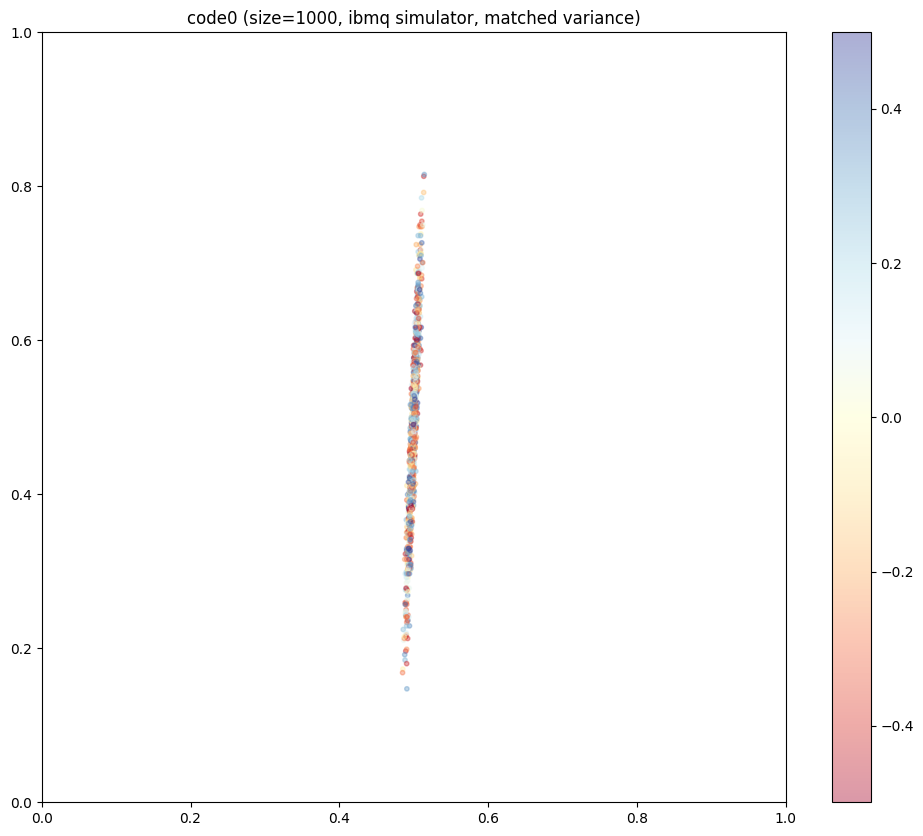

In [67]:
new_outputs = match_variance(data, outputs[:,:2], center=(0.5, 0.5))
plt.figure(figsize=(12,10))
plt.scatter(outputs[:, 0], new_outputs[:, 1], c=inputs[:, 1], cmap='RdYlBu', alpha=0.4, s=10)
plt.colorbar()  # 색상 막대 추가
plt.title(f'code0 (size={i+1}, ibmq simulator, matched variance)')
plt.xlim((0, 1))
plt.ylim((0, 1))